# **Syntactic Processing Assignment - Identifying Entities in Healthcare Data**


## Tables of Contents
* [Problem Statement](#problem-statement)
* [Importing and Installing Necessary Dependecies/Libraries](#importing-and-installing-necessary-dependecies/libraries)
* [Task 1 Data Pre-Processing](#task-1-data-pre-processing)
* [Task 2 Concept Identification](#task-2-concept-identification)
* [Task 3 Defining Features for Conditional Random Field (CRF) Model](#task-3-defining-features-for-conditional-random-field-model)
* [Task 4 Getting the features and the labels of sentences](#task-4-getting-the-features-and-the-labels-of-sentences)
* [Task 5 Defining input and target variables](#task-5-defining-input-and-target-variables)
* [Task 6 Building the CRF Model](#task-6-building-the-CRF-model)
* [Task 7 Evaluation](#task-7-evaluation)
* [Task 8 Identifying Diseases and Treatments using Custom NER](#task-8-identifying-diseases-and-treatments-using-custom-NER)


## Problem Statement
Let’s consider a hypothetical example of a health tech company called ‘BeHealthy’. Suppose ‘BeHealthy’ aims to connect the medical communities with millions of patients across the country.
<br> 

 

‘BeHealthy’ has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

<br> 

So, companies like ‘BeHealthy’ are providing medical services, prescriptions and online consultations and generating huge data day by day.

<br> 

Let’s take a look at the following snippet of medical data that may be generated when a doctor is writing notes to his/her patient or as a review of a therapy that he or she has done.

<br>

“The patient was a 62-year-old man with squamous cell lung cancer, which was first successfully treated by a combination of radiation therapy and chemotherapy.”

 <br>

As you can see in this text, a person with a non-medical background cannot understand the various medical terms. We have taken a simple sentence from a medical data set to understand the problem and where you can understand the terms ‘cancer’ and ‘chemotherapy’. 

 
<br>
Suppose you have been given such a data set in which a lot of text is written related to the medical domain. As you can see in the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text, which you saw in the aforementioned example that the disease mentioned is cancer and its treatment can be identified as chemotherapy using the sentence.

 
<br>
But, note that it is not explicitly mentioned in the dataset about the diseases and their treatment, but somehow, you can build an algorithm to map the diseases and their respective treatment.

 <br>

Suppose you have been asked to determine the disease name and its probable treatment from the dataset and list it out in the form of a table or a dictionary like this.



## Importing and Installing Necessary Dependecies/Libraries

### Installing All Necessary Dependencies

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite
!pip install -U 'scikit-learn<0.24'

The system cannot find the file specified.


### Importing all the Dependencies for the Project

In [2]:
# Importing libraries
import spacy
import textwrap
import warnings
import json
import sklearn_crfsuite
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
import os

from tqdm import tqdm
from sklearn_crfsuite import metrics

warnings.filterwarnings("ignore")
model = spacy.load("en_core_web_sm")

## Task 1 Data Pre-Processing



#### The data set is given in the form of one word per line. Let's figure out how the information below is laid out:

- If a sentence has x words, there will be x lines with one word on each line.

- Also, there are blank lines between the two sentences. The data labels all have the same format.

### Constructing proper sentences from individual words and printing 5 of the sentences.

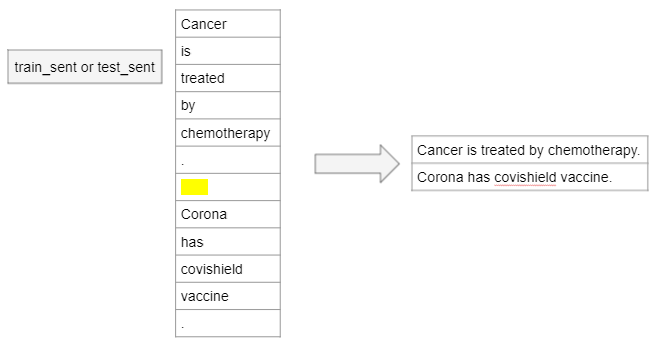

In [3]:
# create a string
amount = u"₹50"
print('Default string: ', amount, '\n', 'Type of string', type(amount), '\n')

# encode to UTF-8 byte format
amount_encoded = amount.encode('utf-8')
print('Encoded to UTF-8: ', amount_encoded, '\n', 'Type of string', type(amount_encoded), '\n')


# sometime later in another computer...
# decode from UTF-8 byte format
amount_decoded = amount_encoded.decode('utf-8')
print('Decoded from UTF-8: ', amount_decoded, '\n', 'Type of string', type(amount_decoded), '\n')

Default string:  ₹50 
 Type of string <class 'str'> 

Encoded to UTF-8:  b'\xe2\x82\xb950' 
 Type of string <class 'bytes'> 

Decoded from UTF-8:  ₹50 
 Type of string <class 'str'> 



In [4]:
# Reading the train and test sentences and labels
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_by_word = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_by_word = test_labels_file.readlines()

In [5]:
# Sanity check to see that the number of tokens and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels_by_word))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels_by_word))

Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


### Function to combine tokens belonging to the same sentence. Sentences are separated by "\n" in the dataset.

In [6]:
def convert_to_sentences(dataset):
    sent_list = []
    sent = ""
    for entity in dataset:
        if entity != '\n':
            sent = sent + entity[:-1] + " "       # Adding word/label to current sentence / sequence of labels 
        else: 
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list

### Converting tokens to sentences and individual labels to sequences of corresponding labels.

In [7]:
train_sentences = convert_to_sentences(train_words)
train_labels = convert_to_sentences(train_labels_by_word)
test_sentences = convert_to_sentences(test_words)
test_labels = convert_to_sentences(test_labels_by_word)

### Printing the First Five Sentences and their Labels for Train Sentences

In [8]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print(train_sentences[i],"\n",train_labels[i],"\n")

First five training sentences and their labels:

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O 

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
 O O O O O O O O O O O O O O O 

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 a

### Printing the First Five Sentences and their Labels for Test Sentences

In [9]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print(test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
 O O O O O O O O O O O O O O O O O O O 

The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
 O O O O O O O O O O O O O O O O O O O O O O O O 

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Fluctuations in ambient temperature are inversely correlated to ch

### Function to read the file if given filename

In [10]:
def read_file(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        content = file.readlines()
    
    sentences = []
    sentence = ""
    word_count = 0
    
    for word in content:
        word = word.strip('\n')
        if word == "":
            sentences.append(sentence.rstrip(" "))
            sentence = ""
        else:
            word_count += 1
            sentence += word + " "
            
    print("Items in File       : ", len(content))
    print("Number of Words     : ", word_count)
    print("Number of Sentences : ", len(sentences))
    
    prefix = "First Sentence      :  "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(sentences[0]))
    
    return sentences


### Counting the number of sentences in the processed train and test dataset

In [11]:
print("Training Sentences")
print("------------------")
train_sentences = read_file("train_sent")

print("\n")
print("Testing Sentences")
print("------------------")
test_sentences = read_file("test_sent")

Training Sentences
------------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599
First Sentence      :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery
                       route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


Testing Sentences
------------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056
First Sentence      :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks ,
                       the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


### Counting the number of lines of labels in the processed train and test dataset.

In [12]:
print("Training Labels")
print("--------------")
train_labels = read_file("train_label")

print("\n")
print("Testing Labels")
print("--------------")
test_labels = read_file("test_label")

Training Labels
--------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599
First Sentence      :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Testing Labels
--------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056
First Sentence      :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


## Task 2 Concept Identification

We will first explore the various concepts present in the dataset. For this exploration I will be using Part of Speech (POS) tagging

### Extracting the tokens that have NOUN or PROPN (Proper Noun) as their PoS tags and finding the frequency of these tags.

In [13]:
# Defining a function for getting POS tags
def get_pos_tags(reviews, labels, tag = ""):
    
    sentence = []
    pos = []
    lemma = []
    text = []
    label = []
    
    i = 1 # Sentence Count
    
    for review, review_labels in tqdm(zip(reviews, labels)):
        #doc = model(review)
        for doc, review_label in zip(review.split(), review_labels.split()):
            s = model(doc)
            for tok in s:
                sentence.append(tag + str(i))
                pos.append(tok.pos_)
                lemma.append(tok.lemma_)
                text.append(tok.text)
                label.append(review_label)
        
        i += 1
    
    return sentence, pos, lemma, text, label

print("Training Sentences")
print("------------------")
train_sentence, train_pos, train_lemma, train_text, train_label = get_pos_tags(train_sentences, train_labels, "train_")
train_frequency_df = pd.DataFrame({'sentence':train_sentence, 'text':train_text,'lemma':train_lemma,'pos':train_pos,'label':train_label})

print("\n")
print("Testing Sentences")
print("------------------")
test_sentence, test_pos, test_lemma, test_text, test_label = get_pos_tags(test_sentences, test_labels, "test_")
test_frequency_df = pd.DataFrame({'sentence':test_sentence, 'text':test_text,'lemma':test_lemma,'pos':test_pos,'label':test_label})

# Convert the data into a dataframe object.
frequency_df = pd.concat((train_frequency_df.copy(), test_frequency_df.copy()),axis=0)

Training Sentences
------------------


2599it [06:30,  6.65it/s]




Testing Sentences
------------------


1056it [02:59,  5.88it/s]


### Printing the top 25 most common tokens having NOUN or PROPN PoS tags

In [14]:
# Get most frequent text forms of nouns
frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['text'].value_counts()[:25]

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: text, dtype: int64

In [15]:
# Get most frequent lemma forms of nouns
frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['lemma'].value_counts()[:25]

patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: lemma, dtype: int64

## Task 3 Defining Features for Conditional Random Field (CRF) Model

### Here we have defined the following features for CRF model building:

- f1 = input word is in lower case;
- f2 = last 3 characters of word;
- f3 = last 2 characters of word;
- f4 = 1; if the word is in uppercase; otherwise, 0
- f5 = 1; if the word is a number; otherwise, 0
- f6 = 1; if the word starts with a capital letter; otherwise, 0
- f7 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0
- f8 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0
- f9 = B; if beginning
- f10 = E; if ending

In [16]:
# Defining the function to get the feature value for one word.
def getFeaturesForOneWord(word_details, pos):
    word_details.reset_index(drop=True, inplace=True)
    word = word_details[pos][0]
    postag = word_details[pos][1]
    
    features = [
        'bias=' + "1.0",
        'word.lower=' + word.lower(),
        'word[-3]=' + word[:-3],
        'word[-2]=' + word[:-2],
        'word.islower=%s' % word.islower(),
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag.isnounpronoun=%s' % (postag in ['NOUN','PROPN']),
    ]
    
    if (pos > 0):
        prev_word = word_details[pos-1][0]
        prev_postag = word_details[pos-1][1]
        
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word[-3]=' + prev_word[:-3],
            'prev_word[-2]=' + prev_word[:-2],
            'prev_word.islower=%s' % prev_word.islower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.istitle=%s' % prev_word.istitle(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_postag=' + prev_postag,
            'prev_postag.isnounpronoun=%s' % (prev_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('BEG')
        
    if (pos < len(word_details) - 1):
        next_word = word_details[pos+1][0]
        next_postag = word_details[pos+1][1]
        
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word[-3]=' + next_word[:-3],
            'next_word[-2]=' + next_word[:-2],
            'next_word.islower=%s' % next_word.islower(),
            'next_word.isupper=%s' % next_word.isupper(),
            'next_word.istitle=%s' % next_word.istitle(),
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_postag=' + next_postag,
            'next_postag.isnounpronoun=%s' % (next_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('END')
        
    return features

## Task 4 Getting the features and the labels of sentences

#### Writing a function to get the features for a sentence.

In [17]:
def get_word_details(item):
    return item["text"], item["pos"]

def getFeaturesForOneSentence(sentence_id):
    words_for_features = frequency_df[frequency_df["sentence"] == sentence_id].apply(get_word_details, axis=1)
    return [getFeaturesForOneWord(words_for_features, pos) for pos in range(len(words_for_features))]

In [18]:
features = getFeaturesForOneSentence("train_1")
prefix = "01 Sentence : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(train_sentences[0]))
print('\n')

i = 1
for feature in features:
    prefix = str('%02d' % i) + " Word     : "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(str(feature)))
    i += 1

01 Sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route ,
              indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


01 Word     : ['bias=1.0', 'word.lower=all', 'word[-3]=', 'word[-2]=A', 'word.islower=False', 'word.isupper=False', 'word.istitle=True',
              'word.isdigit=False', 'postag=PRON', 'postag.isnounpronoun=False', 'BEG', 'next_word.lower=live', 'next_word[-3]=l', 'next_word[-2]=li',
              'next_word.islower=True', 'next_word.isupper=False', 'next_word.istitle=False', 'next_word.isdigit=False', 'next_postag=VERB',
              'next_postag.isnounpronoun=False']
02 Word     : ['bias=1.0', 'word.lower=live', 'word[-3]=l', 'word[-2]=li', 'word.islower=True', 'word.isupper=False', 'word.istitle=False',
              'word.isdigit=False', 'postag=VERB', 'postag.isnounpronoun=False', 'prev_word.lower=all', 'prev_word[-3]='

### Write a function to get the labels of a sentence

In [19]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(sentence_id):
    return frequency_df[frequency_df["sentence"] == sentence_id]["label"]

In [20]:
labels = getLabelsForOneSentence("train_1")

prefix = "01 Labels  : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(" ".join(labels)))

01 Labels  : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


## Task 5 Defining input and target variables
#### Computing X and Y sequence matrices for training and test data. Checking that both sentences and labels are processed

### Define the features' values for each sentence as input variable for CRF model in test and the train dataset

In [21]:
print("Training Sentences")
print("------------------")
X_train = [getFeaturesForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_sentences)))] 

print("\n")
print("Testing Sentences")
print("------------------")
X_test = [getFeaturesForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_sentences)))] 

Training Sentences
------------------


100%|██████████| 2599/2599 [00:34<00:00, 75.44it/s]




Testing Sentences
------------------


100%|██████████| 1056/1056 [00:16<00:00, 64.48it/s]


### Define the labels as the target variable for test and the train dataset

In [22]:
print("Training Labels")
print("------------------")
Y_train = [getLabelsForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_labels)))] 

print("\n")
print("Testing Labels")
print("------------------")
Y_test = [getLabelsForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_labels)))]

Training Labels
------------------


100%|██████████| 2599/2599 [00:33<00:00, 77.03it/s]




Testing Labels
------------------


100%|██████████| 1056/1056 [00:15<00:00, 66.93it/s]


## Task 6 Building the CRF Model

### Hyperparameter Tuning for Best Results

In [23]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF( algorithm='lbfgs',c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Task 7 Evaluation
Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [24]:
Y_pred = crf.predict(X_test)

### Calculating the f1 score using the actual labels and the predicted labels of the test dataset.

In [25]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,2)))

Predicted F1-Score : 92.07 % 


## Task 8 Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

### Creating the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

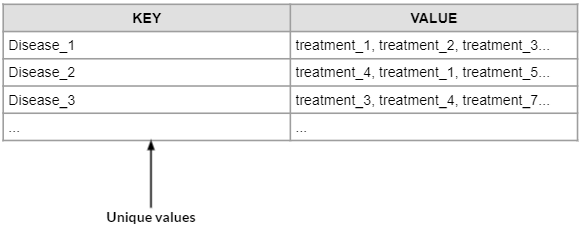

In [26]:
def get_labels_as_array(labels):
    pred_label = []

    for label in labels:
        pred_label.extend(label)
        
    return pred_label

test_frequency_df["pred_label"] = get_labels_as_array(Y_pred)
test_frequency_df.head(5)

,sentence,text,lemma,pos,label,pred_label
0,test_1,Furthermore,furthermore,ADV,O,O
1,test_1,",",",",PUNCT,O,O
2,test_1,when,when,SCONJ,O,O
3,test_1,all,all,PRON,O,O
4,test_1,deliveries,delivery,NOUN,O,O


In [27]:
new_df = test_frequency_df[(test_frequency_df.pred_label != 'O')]
new_df.set_index('sentence',inplace=True)

disease=[]
treatment=[]
sentence=[]
med_dict = {}

for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'pred_label'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df.pred_label == 'D'].loc[i,'text']
            treatment_val = new_df[new_df.pred_label == 'T'].loc[i,'text']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

print(json.dumps(dict(sorted(med_dict.items())), indent = 4))

{
    "AOM drug - resistant S. pneumoniae": "Amoxicillin remains the antibiotic of choice",
    "Barrett 's esophagus": "Acid suppression therapy",
    "Cranial nerve injuries": "persistent conduction blocks",
    "Eisenmenger 's syndrome": "laparoscopic cholecystectomy",
    "Parkinson 's disease": "Microelectrode - guided posteroventral pallidotomy",
    "Pneumocystis carinii pneumonia": "trimethoprim - sulfamethoxazole",
    "Spontaneous splenic rupture": "granulocyte colony - stimulating factor ( G - CSF )",
    "abdominal pain": "thoracic paravertebral block ( tpvb )",
    "acute carbon monoxide poisoning": "Hyperbaric or normobaric oxygen",
    "acute cerebral ischemia": "Antiplatelet therapy",
    "acute migraine treatment": "Sumatriptan",
    "acute myocardial infarction": "thrombolytic treatment",
    "acute occlusion of the middle cerebral artery a large embolus or high - grade stenosis": "thrombolytic therapy",
    "advanced non -- small - cell lung cancer": "paclitaxel plus

In [28]:
# Obtaining a cleaned version of our "Med_dict" dictionary
cleaned_dict = {}
for key in med_dict.keys():
    if med_dict[key] != []:
        cleaned_dict[key] = med_dict[key]
cleaned_dict

{'macrosomic infants in gestational diabetes cases': 'good glycemic control',
 'retinoblastoma': 'radiotherapy',
 'epilepsy ADHD': 'Methylphenidate',
 'unstable angina or non - Q - wave myocardial infarction': 'roxithromycin',
 'coronary - artery disease': 'Antichlamydial antibiotics',
 'primary pulmonary hypertension ( PPH )': 'fenfluramines',
 'essential hypertension': 'moxonidine `',
 'foot infection in diabetic patients': 'G - CSF treatment',
 'stroke hemorrhagic stroke': 'double - bolus alteplase accelerated infusion of alteplase ( P=0.24',
 'cardiac disease': 'fenfluramine - phentermine',
 'rheumatoid arthritis': 'arthrodesis',
 "early Parkinson 's disease": 'Ropinirole monotherapy',
 'sore throat': 'antibiotics',
 'postoperative pain relief': 'single - dose epidural fentanyl ( F )',
 'stress urinary incontinence': 'surgery initial therapy',
 'female stress urinary incontinence': 'surgical treatment',
 'preeclampsia ( proteinuric hypertension': 'intrauterine insemination with don

In [29]:
cleaned_df = pd.DataFrame({"Disease":med_dict.keys(),"Treatments":cleaned_dict.values()})
cleaned_df.head()

,Disease,Treatments
0,macrosomic infants in gestational diabetes cases,good glycemic control
1,retinoblastoma,radiotherapy
2,epilepsy ADHD,Methylphenidate
3,unstable angina or non - Q - wave myocardial i...,roxithromycin
4,coronary - artery disease,Antichlamydial antibiotics


### Predicting the treatment for the disease name: 'hereditary retinoblastoma'

In [30]:
disease=''
treatment=''

input_text = []
input_pos = []
input_label = []

input_sent = 'hereditary retinoblastoma'

input_model = model(input_sent)

for word in input_model:
    input_text.append(word.text)
    input_pos.append(word.pos_)
    input_label.append('D')

details_sent = pd.DataFrame({'text':input_text, 'pos':input_pos,'label':input_label})
words_for_features = details_sent.apply(get_word_details, axis=1)

test_sent = []

for i in range(len(input_sent.split())):
    test_sent.append(getFeaturesForOneWord(words_for_features, i))

for i,tag in enumerate(crf.predict([test_sent])[0]):
    
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr + " "

        if tr in med_dict:
            treatment += med_dict.get(tr) + ", "
            
        if disease.strip() in med_dict:
            treatment += med_dict.get(disease.strip()) + ", "

disease = disease.strip()

if len(treatment) == 0:
    treatment = 'Not Available'
else:
    treatment = treatment.rstrip(", ")
    
print('Identified Disease   :', disease)
print('Identified Treatment :', treatment)


Identified Disease   : retinoblastoma
Identified Treatment : radiotherapy, radiotherapy


# Conclusion 
In this project I was able to create a custom CRF model sucessfully which was able to extract the diseases and correspondings treatments. The model achieved a `Test F1-Score` of `92.07 %`. Ultimately, we were also able to predict the treatment for `Hereditary Retinoblastoma` which is `Radiotherapy`.